![alt text](https://www.codeproject.com/KB/AI/1248963/resnet.png)

In [1]:
!pip install pillow==7
%reload_ext autoreload
%autoreload

In [2]:
!rm -r images
import os 

try:
  os.mkdir("images")
  os.mkdir("images/dogs")
  os.mkdir("images/cats")
except:
  pass

!wget https://i.kinja-img.com/gawker-media/image/upload/s--WFkXeene--/c_scale,f_auto,fl_progressive,q_80,w_800/ol9ceoqxidudap8owlwn.jpg -P images/dogs
!wget https://www.rspcansw.org.au/wp-content/uploads/2017/08/50_a-feature_dogs-and-puppies_mobile.jpg -P images/dogs
  
!wget https://www.catster.com/wp-content/uploads/2018/05/A-gray-cat-crying-looking-upset.jpg -P images/cats
!wget https://www.scarymommy.com/wp-content/uploads/2018/01/c1.jpg?w=700 -P images/cats

rm: cannot remove 'images': No such file or directory
--2020-08-27 08:33:40--  https://i.kinja-img.com/gawker-media/image/upload/s--WFkXeene--/c_scale,f_auto,fl_progressive,q_80,w_800/ol9ceoqxidudap8owlwn.jpg
Resolving i.kinja-img.com (i.kinja-img.com)... 151.101.2.166, 151.101.66.166, 151.101.194.166, ...
Connecting to i.kinja-img.com (i.kinja-img.com)|151.101.2.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32099 (31K) [image/jpeg]
Saving to: ‘images/dogs/ol9ceoqxidudap8owlwn.jpg’

ol9ceoqxidudap8owlw 100%[===================>]  31.35K  --.-KB/s    in 0.01s   

2020-08-27 08:33:40 (2.20 MB/s) - ‘images/dogs/ol9ceoqxidudap8owlwn.jpg’ saved [32099/32099]

--2020-08-27 08:33:40--  https://www.rspcansw.org.au/wp-content/uploads/2017/08/50_a-feature_dogs-and-puppies_mobile.jpg
Resolving www.rspcansw.org.au (www.rspcansw.org.au)... 101.0.86.38
Connecting to www.rspcansw.org.au (www.rspcansw.org.au)|101.0.86.38|:443... connected.
HTTP request sent, awaiting re

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.utils.data as data
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [4]:
batch_size = 1
learning_rate = 0.0002
num_epoch = 100

In [5]:
img_dir = "./images"
img_data = dset.ImageFolder(img_dir, transforms.Compose([
                                      transforms.Resize(256),                   
                                      transforms.RandomResizedCrop(224),        
                                      transforms.RandomHorizontalFlip(),        
                                      transforms.ToTensor(),                    
            ]))

train_loader = data.DataLoader(img_data, batch_size=batch_size,
                            shuffle=True, num_workers=2)

In [6]:
def conv_block_1(in_dim,out_dim,act_fn,stride=1):
  model = nn.Sequential(
      nn.Conv2d(in_dim,out_dim,kernel_size=1,stride=stride),
      act_fn
  )
  return model

def conv_block_3(in_dim,out_dim,act_fn):
  model = nn.Sequential(
      nn.Conv2d(in_dim,out_dim,kernel_size = 3,stride=1,padding=1),
      act_fn
  )
  return model

### 2) Bottle Neck Module
- Bottle Neck 모듈은 [1x1 컨볼루션 -> 3x3 컨볼루션 -> 1x1 컨볼루션]으로 이루어집니다.
- 맨 위에 네트워크 구조에서도 볼 수 있듯이 실선은 크기가 변하지 않는 경우, 점선은 크기가 줄어드는 경우입니다. 
- 이를 한번에 구현하기 위해 down이라는 변수로 크기 감소 여부를 표시하고 조건문으로 경우의 수를 나눠 구현했습니다.
- 또한 ResNet의 Skip-connection은 단순 더하기로 정의되어 있기 때문에 특성지도의 크기를 일치시켜야 합니다. 
- 이를 위해 차원을 맞춰주는 역할로 dim_equalizer라는 것을 정의했습니다.

In [29]:
class BottleNeck(nn.Module):
  def __init__(self,in_dim,mid_dim,out_dim,act_fn,down=False):
    super(BottleNeck,self).__init__()
    self.down = down

    if self.down: # 특정 지도의 크기가 감소하는 경우
      self.layer = nn.Sequential(
          conv_block_1(in_dim,mid_dim,act_fn,2),
          conv_block_3(mid_dim,mid_dim,act_fn),
          conv_block_1(mid_dim,out_dim,act_fn)
      )
      self.downsample = nn.Conv2d(in_dim,out_dim,1,2)
    else: # 특성지도의 크기가 그대로인 경우
      self.layer = nn.Sequential(
          conv_block_1(in_dim,mid_dim,act_fn),
          conv_block_3(mid_dim,mid_dim,act_fn),
          conv_block_1(mid_dim,out_dim,act_fn)
      )
    # 더하기를 위해 차원을 맞춰준다  
    self.dim_equalizer = nn.Conv2d(in_dim,out_dim,kernel_size=1)

  def forward(self,x):
    if self.down:
      downsample = self.downsample(x)
      out = self.layer(x)
      out += downsample
    else:
      out = self.layer(x)
      if x.size() is not out.size():
        x = self.dim_equalizer(x)
      out+=x
    return out

# ResNet

In [42]:
class ResNet(nn.Module):
  def __init__(self,base_dim,num_classes = 2):
    super(ResNet,self).__init__()
    self.act_fn = nn.ReLU()
    self.layer_1 = nn.Sequential(
        nn.Conv2d(3,base_dim,7,2,3),
        nn.ReLU(),
        nn.MaxPool2d(3,2,1)
    )
    self.layer_2 = nn.Sequential(
        BottleNeck(base_dim,base_dim,base_dim*4,self.act_fn),
        BottleNeck(base_dim*4,base_dim,base_dim*4,self.act_fn),
        BottleNeck(base_dim*4,base_dim,base_dim*4,self.act_fn,down=True)
    )
    self.layer_3 = nn.Sequential(
        BottleNeck(base_dim*4,base_dim*2,base_dim*8,self.act_fn),
        BottleNeck(base_dim*8,base_dim*2,base_dim*8,self.act_fn),
        BottleNeck(base_dim*8,base_dim*2,base_dim*8,self.act_fn),
        BottleNeck(base_dim*8,base_dim*2,base_dim*8,self.act_fn,down=True),
    )
    self.layer_4 = nn.Sequential(
        BottleNeck(base_dim*8,base_dim*4,base_dim*16,self.act_fn),
        BottleNeck(base_dim*16,base_dim*4,base_dim*16,self.act_fn),
        BottleNeck(base_dim*16,base_dim*4,base_dim*16,self.act_fn),
        BottleNeck(base_dim*16,base_dim*4,base_dim*16,self.act_fn),
        BottleNeck(base_dim*16,base_dim*4,base_dim*16,self.act_fn),
        BottleNeck(base_dim*16,base_dim*4,base_dim*16,self.act_fn,down=True),
    )
    self.layer_5 = nn.Sequential(
        BottleNeck(base_dim*16,base_dim*8,base_dim*32,self.act_fn),
        BottleNeck(base_dim*32,base_dim*8,base_dim*32,self.act_fn),
        BottleNeck(base_dim*32,base_dim*8,base_dim*32,self.act_fn),
    )
    self.avgpool = nn.AvgPool2d(7,1)
    self.fc_layer = nn.Linear(base_dim*32,num_classes)
  
  def forward(self,x):
    out = self.layer_1(x)
    out = self.layer_2(out)
    out = self.layer_3(out)
    out = self.layer_4(out)
    out = self.layer_5(out)
    out = self.avgpool(out)
    out = out.view(batch_size,-1)
    out = self.fc_layer(out)

    return out


In [43]:
device = ("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [44]:
model = ResNet(base_dim = 64).to(device)

for i in model.children():
  print(i)

loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=learning_rate)

ReLU()
Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
)
Sequential(
  (0): BottleNeck(
    (layer): Sequential(
      (0): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): ReLU()
      )
      (1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
      )
      (2): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): ReLU()
      )
    )
    (dim_equalizer): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
  )
  (1): BottleNeck(
    (layer): Sequential(
      (0): Sequential(
        (0): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): ReLU()
      )
      (1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
      )
      (2): Sequential(
  

In [45]:
loss_arr = []
for i in range(num_epoch):
  for j,[image,label] in enumerate(train_loader):
    x = image.to(device)
    y_ = label.to(device)

    optimizer.zero_grad()
    output = model.forward(x)
    loss = loss_func(output,y_)
    loss.backward()
    optimizer.step()

  if i%10 == 0:
    print(loss)
    loss_arr.append(loss)

tensor(2.2374, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4306, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4512, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4271, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.0898, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.0881, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4374, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4194, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.0943, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.1258, device='cuda:0', grad_fn=<NllLossBackward>)


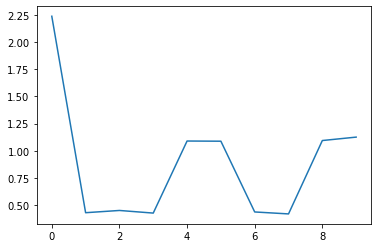

In [47]:
import matplotlib.pyplot as plt
plt.plot(loss_arr)
plt.show()